In [106]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from glob import glob

Prior code from mva:

In [112]:
def read_xy(path: str):
    df = pd.read_csv(path, skipinitialspace=True)
    df['N'] = df.index + 1
    df['r'] = (df.x ** 2 + df.y ** 2) ** 0.5
    df['cr'] = df.r.cummax()
    df['fd'] = np.log(df.N) / np.log(df.cr)

    return df


def read_all(load_dir: str):
    paths = glob(f'{load_dir}/*.csv')
    return [read_xy(path) for path in paths]


# We expect the format of sp data to be:
# ROOT/{probability}/{RUN_ID}.csv

def read_sp_dir(load_dir: str):
    probability = float(Path(load_dir).name)
    return probability, read_all(load_dir)


def read_sp_full(root: str):
    if not Path(root).exists():
        raise Exception("Root does not exist")

    raw_data = [read_sp_dir(load_dir) for load_dir in glob(f'{root}/*')]
    fd_data = [fd_of_dfs(dfs) for (p, dfs) in raw_data]
    probabilities = [p for (p, dfs) in raw_data]
    fd_means, fd_stds = list(zip(*fd_data))
    out = pd.DataFrame(zip(probabilities, fd_means, fd_stds), columns=['p', 'fd_mean', 'fd_std'])
    out.sort_values(by='p', inplace=True)

    return out

In [ ]:
def convergent_tail_index(series, tol):
    diffs = np.abs(np.ediff1d(series))
    for i in range(0, len(diffs)):
        if np.max(diffs[i:]) <= tol:
            return i

    # No convergence found
    return None


def mean_of_tail(series, tol=0.05):
    tail_index = convergent_tail_index(series, tol)
    if tail_index is None:
        print("Ahh fuck")

    return np.mean(series[tail_index:])


def fd_of_dfs(dfs):
    fds = [mean_of_tail(df.fd, 0.001) for df in dfs]
    fds_clean = [f for f in fds if f < np.inf]
    return np.mean(fds_clean), np.std(fds_clean)

In [113]:
c_sticking_probability = read_sp_full("../data/stick-probability")

/Users/joshuacoles/Library/Caches/pypoetry/virtualenvs/data-analysis-B4Au_hWl-py3.10/lib/python3.10/site-packages/numpy/lib/arraysetops.py:89: RuntimeWarning: invalid value encountered in subtract
  return ary[1:] - ary[:-1]


In [121]:
rust_sticking_probability = read_sp_full("../data/rust-sticking-probability")

/Users/joshuacoles/Library/Caches/pypoetry/virtualenvs/data-analysis-B4Au_hWl-py3.10/lib/python3.10/site-packages/numpy/lib/arraysetops.py:89: RuntimeWarning: invalid value encountered in subtract
  return ary[1:] - ary[:-1]


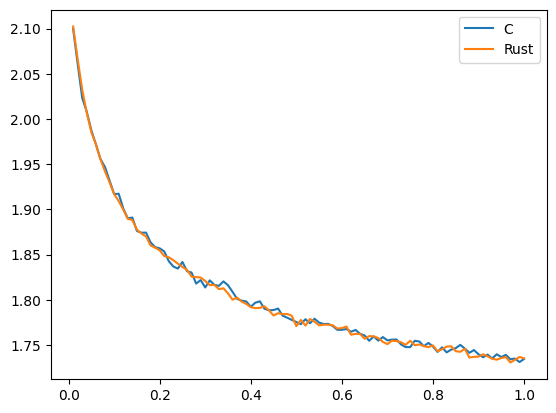

In [124]:
plt.plot(c_sticking_probability.p, c_sticking_probability.fd_mean)
plt.plot(rust_sticking_probability.p, rust_sticking_probability.fd_mean)
plt.legend(["C", "Rust"])

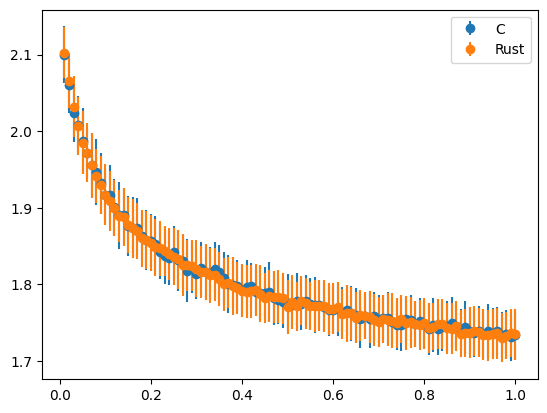

In [125]:
plt.errorbar(c_sticking_probability.p, c_sticking_probability.fd_mean, c_sticking_probability.fd_std, fmt="o")
plt.errorbar(rust_sticking_probability.p, rust_sticking_probability.fd_mean, rust_sticking_probability.fd_std, fmt="o")
plt.legend(["C", "Rust"])

Hmmm even with a different RNG I still get a dip around 0.6, I think theres something hiding there